In [19]:
from bankingSystemRL import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
import torch
import torch.nn as nn

# Define the policy function as a PyTorch model
class PolicyFunction(nn.Module):
  def __init__(self, input_size, output_size):
    super(PolicyFunction, self).__init__()
    # self.fc1 = nn.Linear(input_size, hidden_size)
    # self.fc1.weight.data.fill_(0.)
    # self.fc1.bias.data.fill_(0.)
    # self.fc2 = nn.Linear(hidden_size, output_size)
    # self.fc2.weight.data.fill_(0.)
    # self.fc2.bias.data.fill_(0.)
    self.fc1 = nn.Linear(input_size, 1)
    self.fc1.weight.data.fill_(0.)
    self.fc1.bias.data.fill_(0.)
    
    
  
  def forward(self, x):
    x = self.fc1(x)
    # x = torch.relu(x)
    # x = self.fc2(x)
    x = torch.sigmoid(x)
    return x

policy = PolicyFunction(6, 1)
# mean = policy(torch.tensor([0.0000, 0.0000, 0.0703, 0.0000, 0.0000, 0.0703], dtype=torch.float))
# dist = torch.distributions.Normal(mean, 0.01)
# a = dist.sample()
# like = dist.log_prob(a)
# a.item()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [20]:
modele = pd.read_csv("balanceSheetAnalysis/banksData_2022.csv")["equity"][:100].values.reshape(-1,1)
def R_tau(model):
    value = (model.e - modele)/modele
    return value.flatten()

In [22]:
Rewards = []
# simulation and data collection
simulationSteps = 500
gradientSteps = 100
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)

for sim in [0,20,40,60,70]:
    print(sim)
    policy.load_state_dict(torch.load('models/model' + str(sim) + '.pt'))
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                        leverageRatio = 11.0,                                     # leverage ratio upper bound for all banks
                        capitalReserve = 0.0,                                     # capital reserve as a ratio of portfolio value
                        num_borrowing= 20,                                        # number of borrowing request per bank per step
                        sizeOfBorrowing = 1,                                      # size of borrowing as a ratio of equity capital
                        num_banks=100,                                            # number of banks in the system 
                        alpha = 0.5,                                              # portfolio recovery rate                           
                        beta = 0.9,                                               # interbank loan recovery rate
                        fedRate = 0.04/252,                                       # interest rate on borrowing   
                        portfolioReturnRate = 0.03/252,                                  # return rate on portfolio
                        liquidityShockNum = 2,                                    # number of liquidity shocks per step      
                        shockSize = 0.1,                                           # size of the shock
                        shockDuration =  [simulationSteps // 10 * 6, simulationSteps // 10 * 7], # duration of the shock
                        policy = policy)                                                    # policy function weights
                        
    #model.datacollector.collect(model)
    for i in tqdm(range(simulationSteps)):
        model.simulate()
    #agent_data = model.datacollector.get_agent_vars_dataframe()
    #model_data = model.datacollector.get_model_vars_dataframe()

    # policy.zero_grad()
    reward = R_tau(model)
    # loss = 0
    # for i in range(len(reward)):
    #     loss -= reward[i] * model.schedule.agents[i].log_probs
    # loss.backward()
    # optimizer.step()
    #torch.save(policy.state_dict(), 'models/model' + str(sim) + '.pt')
    Rewards.append(reward)
np.save("Rewards", Rewards)

  0%|          | 0/500 [00:00<?, ?it/s]

0


  0%|          | 0/500 [00:00<?, ?it/s]

20


  0%|          | 0/500 [00:00<?, ?it/s]

40


  0%|          | 0/500 [00:00<?, ?it/s]

60


  0%|          | 0/500 [00:00<?, ?it/s]

70


100%|██████████| 500/500 [06:17<00:00,  1.33it/s]


In [26]:
len(Rewards)

5

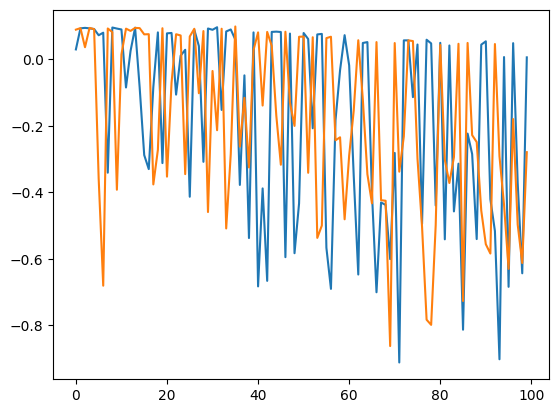

In [28]:
for r in [0,4]:
    plt.plot(Rewards[r], label="0")

In [5]:
params = []
for i in range(70):
    params.append(torch.load('models/model' + str(i) + '.pt')['fc1.weight'].numpy()[0])

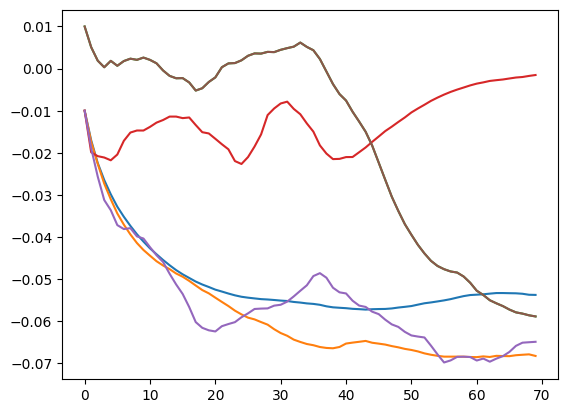

In [9]:
params = np.array(params)
for i in range(6):
    plt.plot(params[:,i])

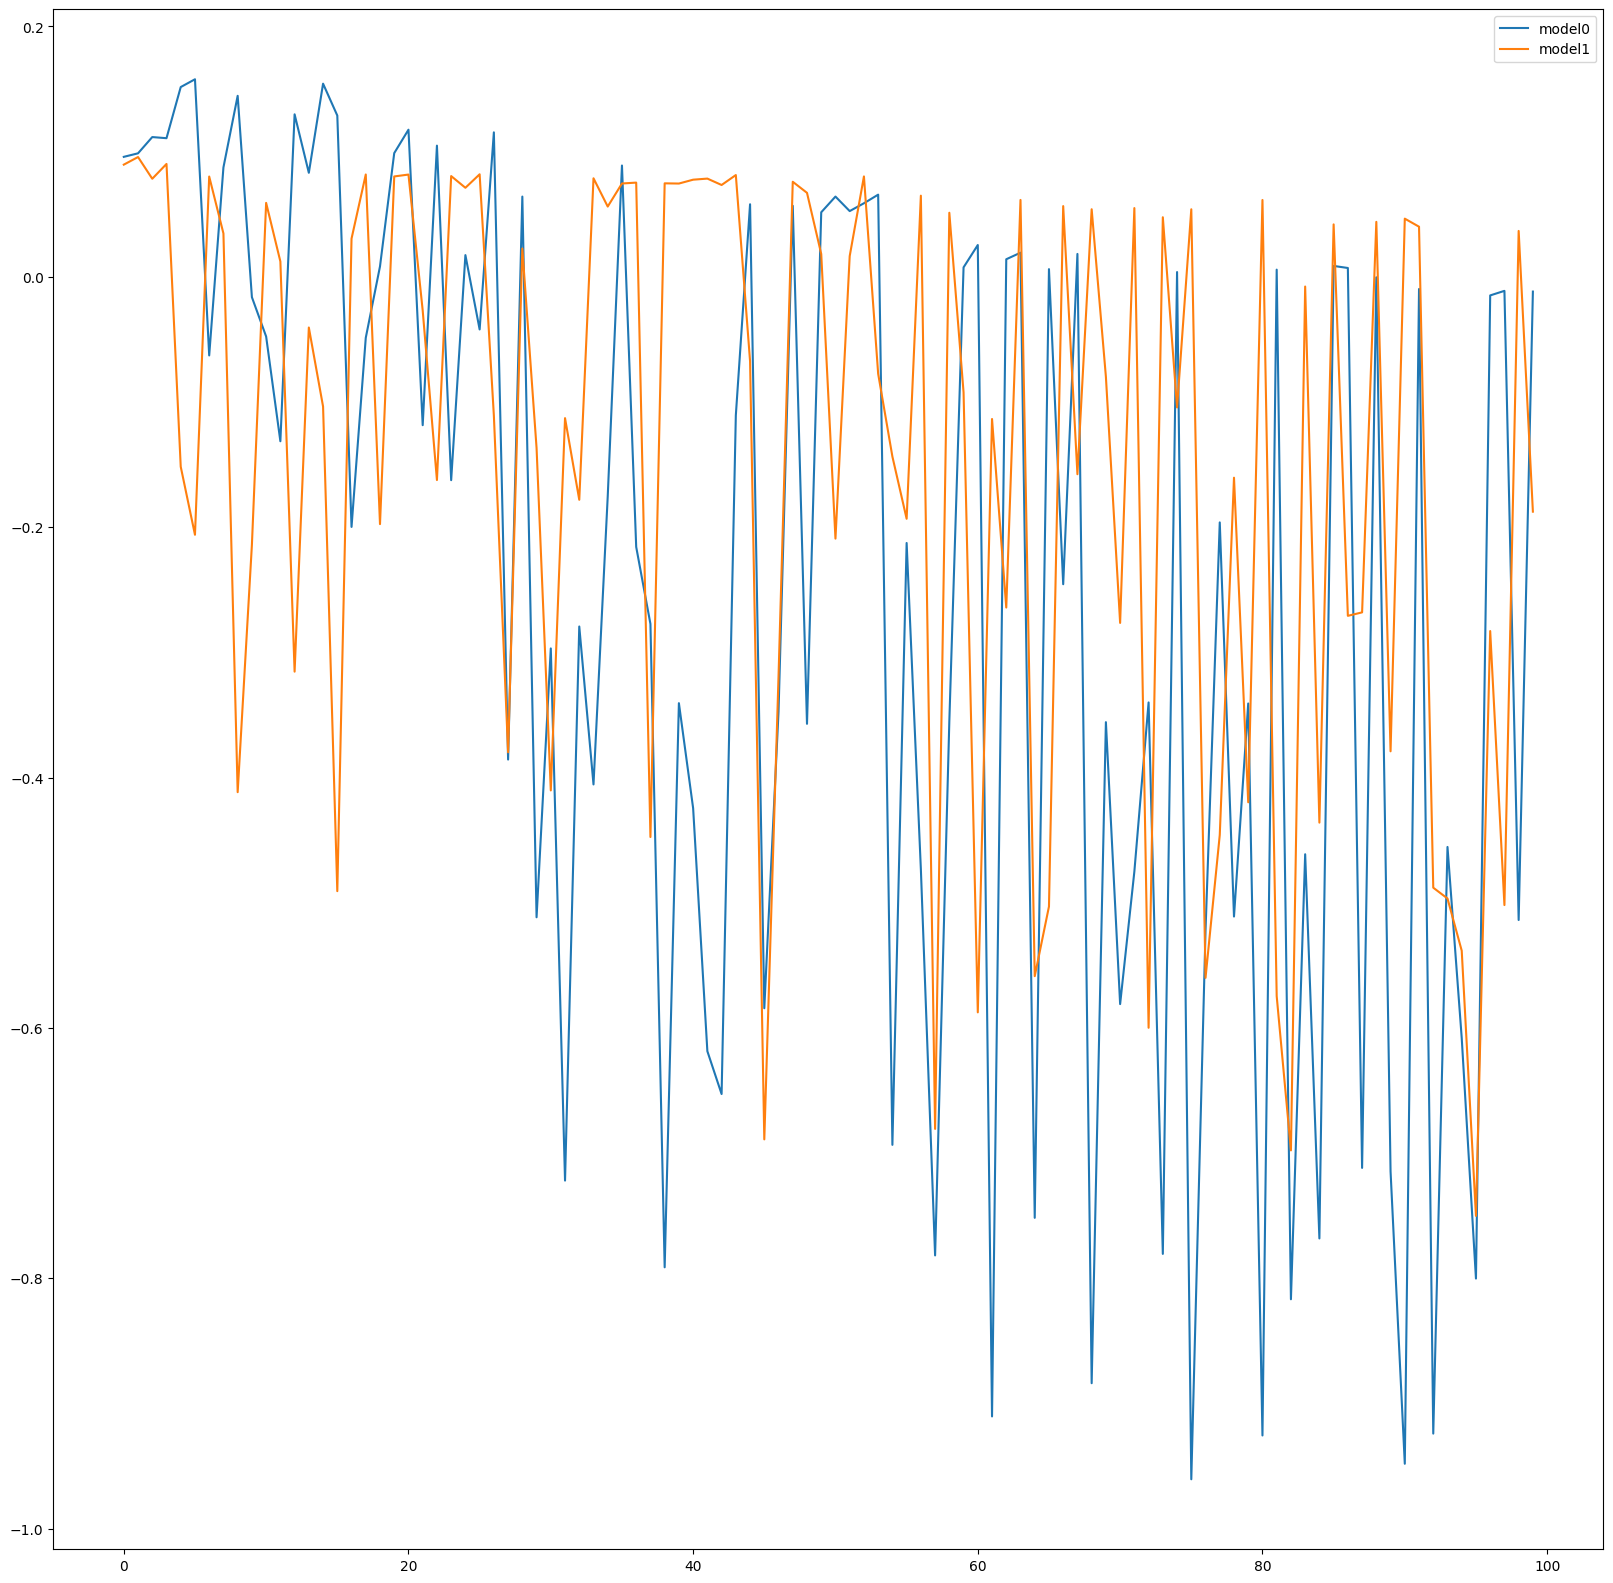

In [22]:
plt.plot(Rewards[0], label="model0")
plt.plot(Rewards[1], label="model1")
plt.legend()